In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import io
import glob
import random

import tensorflow as tf
from sklearn.preprocessing import StandardScaler, normalize
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K
from IPython.display import display

In [ ]:
brain_df = pd.read_csv('/content/drive/MyDrive/ML Project/lgg-mri-segmentation/kaggle_3m/ImgAndMaskPath.csv')
brain_df

patient_id  ... mask
0     TCGA_CS_4944_20010208  ...    0
1     TCGA_CS_4944_20010208  ...    0
2     TCGA_CS_4944_20010208  ...    0
3     TCGA_CS_4944_20010208  ...    0
4     TCGA_CS_4944_20010208  ...    0
...                     ...  ...  ...
3924  TCGA_HT_8113_19930809  ...    0
3925  TCGA_HT_8113_19930809  ...    0
3926  TCGA_HT_8113_19930809  ...    0
3927  TCGA_HT_8113_19930809  ...    0
3928  TCGA_HT_8113_19930809  ...    0

[3929 rows x 4 columns]

In [ ]:
import plotly.graph_objects as go

In [ ]:
fig = go.Figure([go.Bar(x=brain_df['mask'].value_counts().index, 
                        y=brain_df['mask'].value_counts(), 
                        width=[.4, .4]
                       )
                ])
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=4, opacity=0.4
                 )
fig.update_layout(title_text="Mask Count Plot",
                  width=700,
                  height=550,
                  yaxis=dict(
                             title_text="Count",
                             tickmode="array",
                             titlefont=dict(size=20)
                           )
                 )
fig.update_yaxes(automargin=True)
fig.show()

In [8]:
def visualization_grid(img_count):
  count = 0
  fig, axs = plt.subplots(img_count, 3, figsize = (20, 50))
  for i in range(len(brain_df)):
      if brain_df['mask'][i] ==1 and count <img_count:
          img = io.imread(brain_df.image_path[i])
          axs[count][0].title.set_text('Brain MRI')
          axs[count][0].imshow(img)

          mask = io.imread(brain_df.mask_path[i])
          axs[count][1].title.set_text('Mask')
          axs[count][1].imshow(mask, cmap = 'gray')


          img[mask == 255] = (255, 0, 0)
          axs[count][2].title.set_text('MRI with Mask')
          axs[count][2].imshow(img)
          count+=1

  fig.tight_layout()

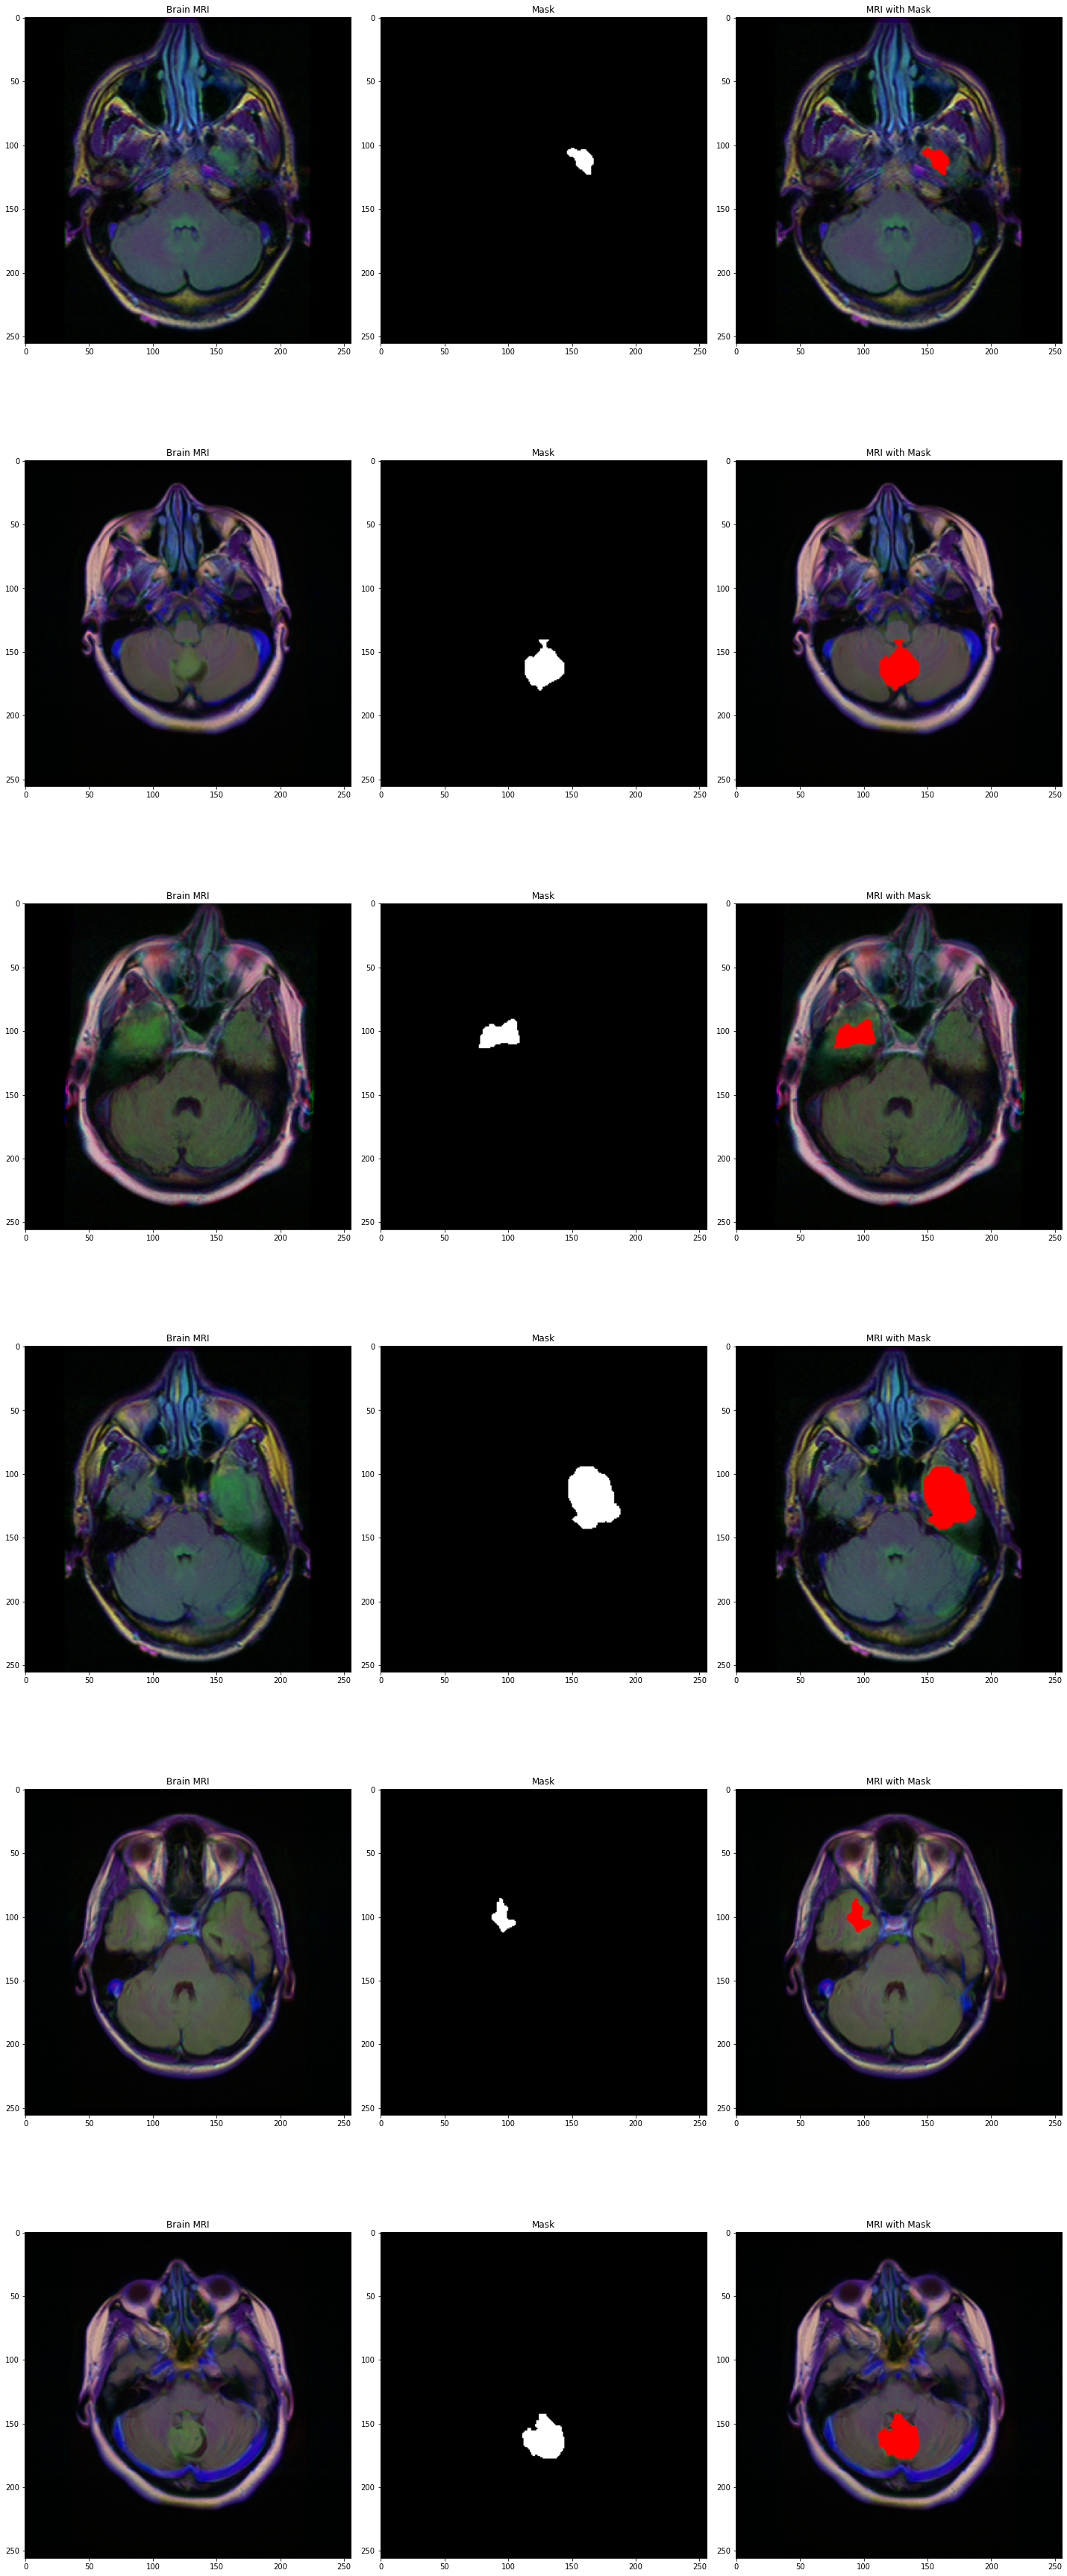

In [12]:
visualization_grid(6)

## Skip this part and goto this [cell](https://colab.research.google.com/drive/1fs10HVurota63WhL5vKzYLceY2GUay4Q?authuser=3#scrollTo=kHR4bnA99a3c&line=2&uniqifier=1) (BUILDING A SEGMENTATION MODEL TO LOCALIZE TUMOR) part

## Creating Train, Val and Test Sets and Data Augmentation

In [13]:
brain_df_train = brain_df.drop(columns=['patient_id'])
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [14]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train, test_size=0.15)

In [16]:
datagen = ImageDataGenerator(rescale=1./255., validation_split=0.1)

train_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='mask',
                                              subset='training',
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )
valid_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='mask',
                                              subset='validation',
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_dataframe(test,
                                                  directory='./',
                                                  x_col='image_path',
                                                  y_col='mask',
                                                  class_mode='categorical',
                                                  batch_size=16,
                                                  shuffle=False,
                                                  target_size=(256,256)
                                                 )

Found 3006 validated image filenames belonging to 2 classes.
Found 333 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


## TRAIN A CLASSIFIER MODEL TO DETECT IF TUMOR EXISTS OR NOT

In [17]:
from tensorflow.keras.applications.resnet50 import ResNet50

clf_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))
clf_model.summary()

94773248/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
__________________________

In [18]:
for layer in clf_model.layers:
    layers.trainable = False

**Training the last layers of ResNet50 Fully connected layers with the brain tumor segmentation dataset**

In [19]:
head = clf_model.output
head = AveragePooling2D(pool_size=(4,4))(head)
head = Flatten(name='Flatten')(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.3)(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.3)(head)
head = Dense(2, activation='softmax')(head)

model = Model(clf_model.input, head)
model.compile(loss = 'categorical_crossentropy', 
              optimizer='adam', 
              metrics= ["accuracy"]
             )
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [20]:
earlystopping = EarlyStopping(monitor='val_loss', 
                              mode='min', 
                              verbose=1, 
                              patience=15
                             )
checkpointer = ModelCheckpoint(filepath="clf-resnet-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )
callbacks = [checkpointer, earlystopping, reduce_lr]

In [21]:
with tf.device("/GPU:0"):
  h = model.fit(train_generator, 
              steps_per_epoch= train_generator.n // train_generator.batch_size, 
              epochs = 20, 
              validation_data= valid_generator, 
              validation_steps= valid_generator.n // valid_generator.batch_size, 
              callbacks=[checkpointer, earlystopping])

Epoch 1/50
163/187 [=========================>....] - ETA: 1:34 - loss: 1.1100 - accuracy: 0.6990

KeyboardInterrupt: ignored

In [ ]:
# Saving the ResNet Trained Model
model.save('/content/drive/MyDrive/ML Project/models/ResNet_Trained_model.h5')

In [22]:
# Saving model achitecture in json file
model_json = model.to_json()
with open("clf-resnet-model.json", "w") as json_file:
    json_file.write(model_json)

In [23]:
h.history.keys()

NameError: ignored

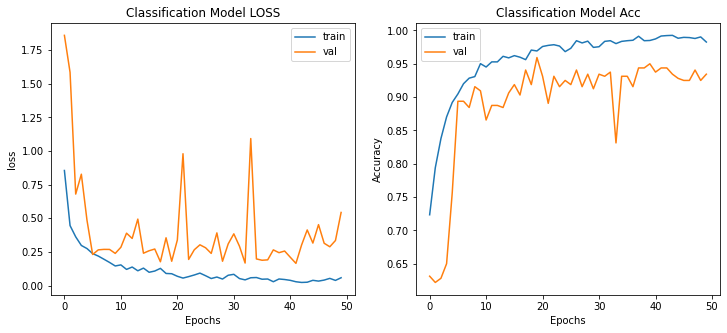

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h.history['loss']);
plt.plot(h.history['val_loss']);
plt.title("Classification Model LOSS");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h.history['accuracy']);
plt.plot(h.history['val_accuracy']);
plt.title("Classification Model Acc");
plt.ylabel("Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [ ]:
_, acc = model.evaluate(test_generator)
print("Test accuracy : {} %".format(acc*100))

37/37 [==============================] - 138s 4s/step - loss: 0.6129 - accuracy: 0.9153
Test accuracy : 91.52542352676392 %


0.9152542372881356
              precision    recall  f1-score   support

           0       0.90      0.97      0.94       378
           1       0.95      0.81      0.87       212

    accuracy                           0.92       590
   macro avg       0.92      0.89      0.90       590
weighted avg       0.92      0.92      0.91       590



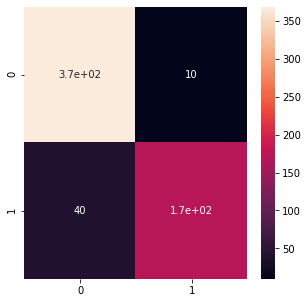

In [ ]:
prediction = model.predict(test_generator)

pred = np.argmax(prediction, axis=1)
#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy = accuracy_score(original, pred)
print(accuracy)

cm = confusion_matrix(original, pred)

report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True);

## BUILDING A SEGMENTATION MODEL TO LOCALIZE TUMOR

In [24]:
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

(1373, 4)

In [25]:
# creating test, train and val sets
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)
print("Train size is {}, valid size is {} & test size is {}".format(len(X_train), len(X_val), len(X_test)))

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

Train size is 1167, valid size is 103 & test size is 103


In [26]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, ids , mask, image_dir = './', batch_size = 16, img_h = 256, img_w = 256, shuffle = True):

    self.ids = ids
    self.mask = mask
    self.image_dir = image_dir
    self.batch_size = batch_size
    self.img_h = img_h
    self.img_w = img_w
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    'Get the number of batches per epoch'

    return int(np.floor(len(self.ids)) / self.batch_size)

  def __getitem__(self, index):
    'Generate a batch of data'

    #generate index of batch_size length
    indexes = self.indexes[index* self.batch_size : (index+1) * self.batch_size]

    #get the ImageId corresponding to the indexes created above based on batch size
    list_ids = [self.ids[i] for i in indexes]

    #get the MaskId corresponding to the indexes created above based on batch size
    list_mask = [self.mask[i] for i in indexes]


    #generate data for the X(features) and y(label)
    X, y = self.__data_generation(list_ids, list_mask)

    #returning the data
    return X, y

  def on_epoch_end(self):
    'Used for updating the indices after each epoch, once at the beginning as well as at the end of each epoch'
    
    #getting the array of indices based on the input dataframe
    self.indexes = np.arange(len(self.ids))

    #if shuffle is true, shuffle the indices
    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_ids, list_mask):
    'generate the data corresponding the indexes in a given batch of images'

    # create empty arrays of shape (batch_size,height,width,depth) 
    #Depth is 3 for input and depth is taken as 1 for output becasue mask consist only of 1 channel.
    X = np.empty((self.batch_size, self.img_h, self.img_w, 3))
    y = np.empty((self.batch_size, self.img_h, self.img_w, 1))

    #iterate through the dataframe rows, whose size is equal to the batch_size
    for i in range(len(list_ids)):
      #path of the image
      img_path = str(list_ids[i])
      
      #mask path
      mask_path = str(list_mask[i])
      
      #reading the original image and the corresponding mask image
      img = io.imread(img_path)
      mask = io.imread(mask_path)

      #resizing and coverting them to array of type float64
      img = cv2.resize(img,(self.img_h,self.img_w))
      img = np.array(img, dtype = np.float64)
      
      mask = cv2.resize(mask,(self.img_h,self.img_w))
      mask = np.array(mask, dtype = np.float64)

      #standardising 
      img -= img.mean()
      img /= img.std()
      
      mask -= mask.mean()
      mask /= mask.std()
      
      #Adding image to the empty array
      X[i,] = img
      
      #expanding the dimnesion of the image from (256,256) to (256,256,1)
      y[i,] = np.expand_dims(mask, axis = 2)
    
    #normalizing y
    y = (y > 0).astype(int)

    return X, y

train_data = DataGenerator(train_ids, train_mask)
val_data = DataGenerator(val_ids, val_mask)

### Implemeting ResUNet Architecture Model

In [27]:
def resblock(X, f):
    '''
    function for creating res block
    '''
    X_copy = X  #copy of input
    
    # main path
    X = Conv2D(f, kernel_size=(1,1), kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = Conv2D(f, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    
    # shortcut path
    X_copy = Conv2D(f, kernel_size=(1,1), kernel_initializer='he_normal')(X_copy)
    X_copy = BatchNormalization()(X_copy)
    
    # Adding the output from main path and short path together
    X = Add()([X, X_copy])
    X = Activation('relu')(X)
    
    return X

def upsample_concat(x, skip):
    '''
    funtion for upsampling image
    '''
    X = UpSampling2D((2,2))(x)
    merge = Concatenate()([X, skip])
    
    return merge

In [29]:
def ResUNet(input_width, input_height):
  X_input = Input((input_height, input_width,3)) #iniating tensor of input shape

  # Stage 1
  conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(X_input)
  conv_1 = BatchNormalization()(conv_1)
  conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv_1)
  conv_1 = BatchNormalization()(conv_1)
  pool_1 = MaxPool2D((2,2))(conv_1)

  # stage 2
  conv_2 = resblock(pool_1, 32)
  pool_2 = MaxPool2D((2,2))(conv_2)

  # Stage 3
  conv_3 = resblock(pool_2, 64)
  pool_3 = MaxPool2D((2,2))(conv_3)

  # Stage 4

  conv_4 = resblock(pool_3, 128)
  pool_4 = MaxPool2D((2,2))(conv_4)

  # Stage 5 (bottle neck)
  conv_5 = resblock(pool_4, 256)

  # Upsample Stage 1
  up_1 = upsample_concat(conv_5, conv_4)
  up_1 = resblock(up_1, 128)

  # Upsample Stage 2
  up_2 = upsample_concat(up_1, conv_3)
  up_2 = resblock(up_2, 64)

  # Upsample Stage 3
  up_3 = upsample_concat(up_2, conv_2)
  up_3 = resblock(up_3, 32)

  # Upsample Stage 4
  up_4 = upsample_concat(up_3, conv_1)
  up_4 = resblock(up_4, 16)

  # final output
  out = Conv2D(1, (1,1), kernel_initializer='he_normal', padding='same', activation='sigmoid')(up_4)

  seg_model = Model(X_input, out)
  return seg_model

In [30]:
res_model = ResUNet(256,256)

In [31]:
res_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 256, 256, 16) 448         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_26 (BatchNo (None, 256, 256, 16) 64          conv2d_27[0][0]                  
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 256, 256, 16) 2320        batch_normalization_26[0][0]     
____________________________________________________________________________________________

## Training Segmentation Model

In [32]:
# Define a custom loss function for ResUNet model
from keras.losses import binary_crossentropy

epsilon = 1e-5
smooth = 1

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

In [34]:
# compling model and callbacks functions
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
seg_model.compile(optimizer = adam, 
                  loss = focal_tversky, 
                  metrics = [tversky]
                 )
#callbacks
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min', 
                              verbose=1, 
                              patience=20
                             )
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="ResUNet1-segModel-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )

In [35]:
with tf.device("/GPU:0"):
  h = seg_model.fit(train_data, 
                  epochs = 60, 
                  validation_data = val_data,
                  callbacks = [checkpointer, earlystopping, reduce_lr]
                 )

Epoch 1/60
72/72 [==============================] - 434s 6s/step - loss: 0.8907 - tversky: 0.1427 - val_loss: 0.8273 - val_tversky: 0.2231

Epoch 00001: val_loss improved from inf to 0.82734, saving model to ResUNet1-segModel-weights.hdf5
Epoch 2/60
72/72 [==============================] - 19s 268ms/step - loss: 0.6329 - tversky: 0.4521 - val_loss: 0.5669 - val_tversky: 0.5300

Epoch 00002: val_loss improved from 0.82734 to 0.56686, saving model to ResUNet1-segModel-weights.hdf5
Epoch 3/60
72/72 [==============================] - 14s 189ms/step - loss: 0.3914 - tversky: 0.7118 - val_loss: 0.5911 - val_tversky: 0.5029

Epoch 00003: val_loss did not improve from 0.56686
Epoch 4/60
72/72 [==============================] - 14s 191ms/step - loss: 0.3485 - tversky: 0.7530 - val_loss: 0.5559 - val_tversky: 0.5423

Epoch 00004: val_loss improved from 0.56686 to 0.55585, saving model to ResUNet1-segModel-weights.hdf5
Epoch 5/60
72/72 [==============================] - 14s 191ms/step - loss: 0.3

In [36]:
# Saving the ResNet Trained Model
seg_model.save('/content/drive/MyDrive/ML Project/models/ResUNet1_Segmen_model.h5')

In [37]:
# Saving seg_model achitecture in json file
seg_model_json = seg_model.to_json()
with open("ResUNet1-seg-model.json", "w") as json_file:
    json_file.write(seg_model_json)

In [ ]:
from tensorflow.keras.models import load_model
seg_model.load_weights('/content/drive/MyDrive/ML Project/models/ResUNet-segModel-weights.hdf5')

### SEGMENTATION MODEL EVALUATION

In [38]:
h.history.keys()

dict_keys(['loss', 'tversky', 'val_loss', 'val_tversky', 'lr'])

In [41]:
def plot_segmentation_loss_w_tversky(hist, b_seg_model):
  plt.figure(figsize=(12,5))
  plt.subplot(1,2,1)
  plt.plot(h.history['loss'])
  plt.plot(h.history['val_loss'])
  plt.title("SEG Model focal tversky Loss")
  plt.ylabel("focal tversky loss")
  plt.xlabel("Epochs")
  plt.legend(['train', 'val'])

  plt.subplot(1,2,2)
  plt.plot(h.history['tversky'])
  plt.plot(h.history['val_tversky'])
  plt.title("SEG Model tversky score")
  plt.ylabel("tversky Accuracy")
  plt.xlabel("Epochs")
  plt.legend(['train', 'val'])
  test_ids = list(X_test.image_path)
  test_mask = list(X_test.mask_path)
  test_data = DataGenerator(test_ids, test_mask)
  _, tv = b_seg_model.evaluate(test_data)
  print("Segmentation tversky is {:.2f}%".format(tv*100))

### SEGMENTATION MODEL PREFORMACE, COMBINING CLASSIFICATION AND SEGMENTAION MODEL BUILDING PIPELINE

In [44]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/ML Project/models/ResNet_Trained_model.h5')

In [43]:
def prediction(test, model, model_seg):
    '''
    Predcition function which takes dataframe containing ImageID as Input and perform 2 type of prediction on the image
    Initially, image is passed through the classification network which predicts whether the image has defect or not, if the model
    is 99% sure that the image has no defect, then the image is labeled as no-defect, if the model is not sure, it passes the image to the
    segmentation network, it again checks if the image has defect or not, if it has defect, then the type and location of defect is found
    '''
    # empty list to store results
    mask, image_id, has_mask = [], [], []
    
    #itetrating through each image in test data
    for i in test.image_path:
        
        img = io.imread(i)
        #normalizing
        img = img *1./255.
        #reshaping
        img = cv2.resize(img, (256,256))
        # converting img into array
        img = np.array(img, dtype=np.float64)
        #reshaping the image from 256,256,3 to 1,256,256,3
        img = np.reshape(img, (1,256,256,3))
        
        #making prediction for tumor in image
        is_defect = model.predict(img)
        
        #if tumour is not present we append the details of the image to the list
        if np.argmax(is_defect)==0:
            image_id.append(i)
            has_mask.append(0)
            mask.append('No mask :)')
            continue
        
        #Creating a empty array of shape 1,256,256,1
        X = np.empty((1,256,256,3))
        # read the image
        img = io.imread(i)
        #resizing the image and coverting them to array of type float64
        img = cv2.resize(img, (256,256))
        img = np.array(img, dtype=np.float64)
        
        # standardising the image
        img -= img.mean()
        img /= img.std()
        #converting the shape of image from 256,256,3 to 1,256,256,3
        X[0,] = img
        
        #make prediction of mask
        predict = model_seg.predict(X)
        
        # if sum of predicted mask is 0 then there is not tumour
        if predict.round().astype(int).sum()==0:
            image_id.append(i)
            has_mask.append(0)
            mask.append('No mask :)')
        else:
        #if the sum of pixel values are more than 0, then there is tumour
            image_id.append(i)
            has_mask.append(1)
            mask.append(predict)
            
    return pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})

In [51]:
# making prediction
def prediction_with_seg_vis(model, b_seg_model, model_hist):
  df_pred = prediction(X_test, model, b_seg_model)
  df_pred = X_test.merge(df_pred, on='image_path')
  plot_segmentation_loss_w_tversky(model_hist, b_seg_model)
  correct_count = df_pred['mask']==df_pred['has_mask']
  out = correct_count.value_counts()
  print("Prediction Accuracy is {:.5f}%".format(out[1]/sum(out)*100))
  #visualizing prediction
  count = 0
  fig, axs = plt.subplots(5,5, figsize=(30,40))

  for i in range(len(df_pred)):
      if df_pred.has_mask[i]==1 and count<5:
          #read mri images
          img = io.imread(df_pred.image_path[i])
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          axs[count][0].imshow(img)
          axs[count][0].title.set_text('Brain MRI')
          
          #read original mask
          mask = io.imread(df_pred.mask_path[i])
          axs[count][1].imshow(mask)
          axs[count][1].title.set_text('Original Mask')
          
          #read predicted mask
          pred = np.array(df_pred.predicted_mask[i]).squeeze().round()
          axs[count][2].imshow(pred)
          axs[count][2].title.set_text('AI predicted mask')
          
          #overlay original mask with MRI
          img[mask==255] = (255,0,0)
          axs[count][3].imshow(img)
          axs[count][3].title.set_text('Brain MRI with original mask (Ground Truth)')
          
          #overlay predicted mask and MRI
          img_ = io.imread(df_pred.image_path[i])
          img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
          img_[pred==1] = (0,255,150)
          axs[count][4].imshow(img_)
          axs[count][4].title.set_text('MRI with AI PREDICTED MASK')
          
          count +=1
      if (count==15):
          break

  fig.tight_layout()

6/6 [==============================] - 1s 171ms/step - loss: 0.1865 - tversky: 0.8921
Segmentation tversky is 89.21%
Prediction Accuracy is 89.32039%


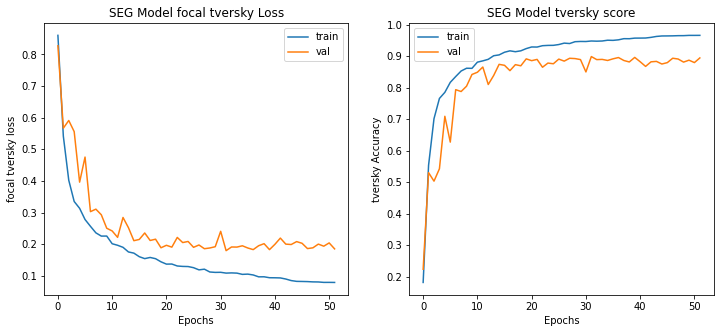

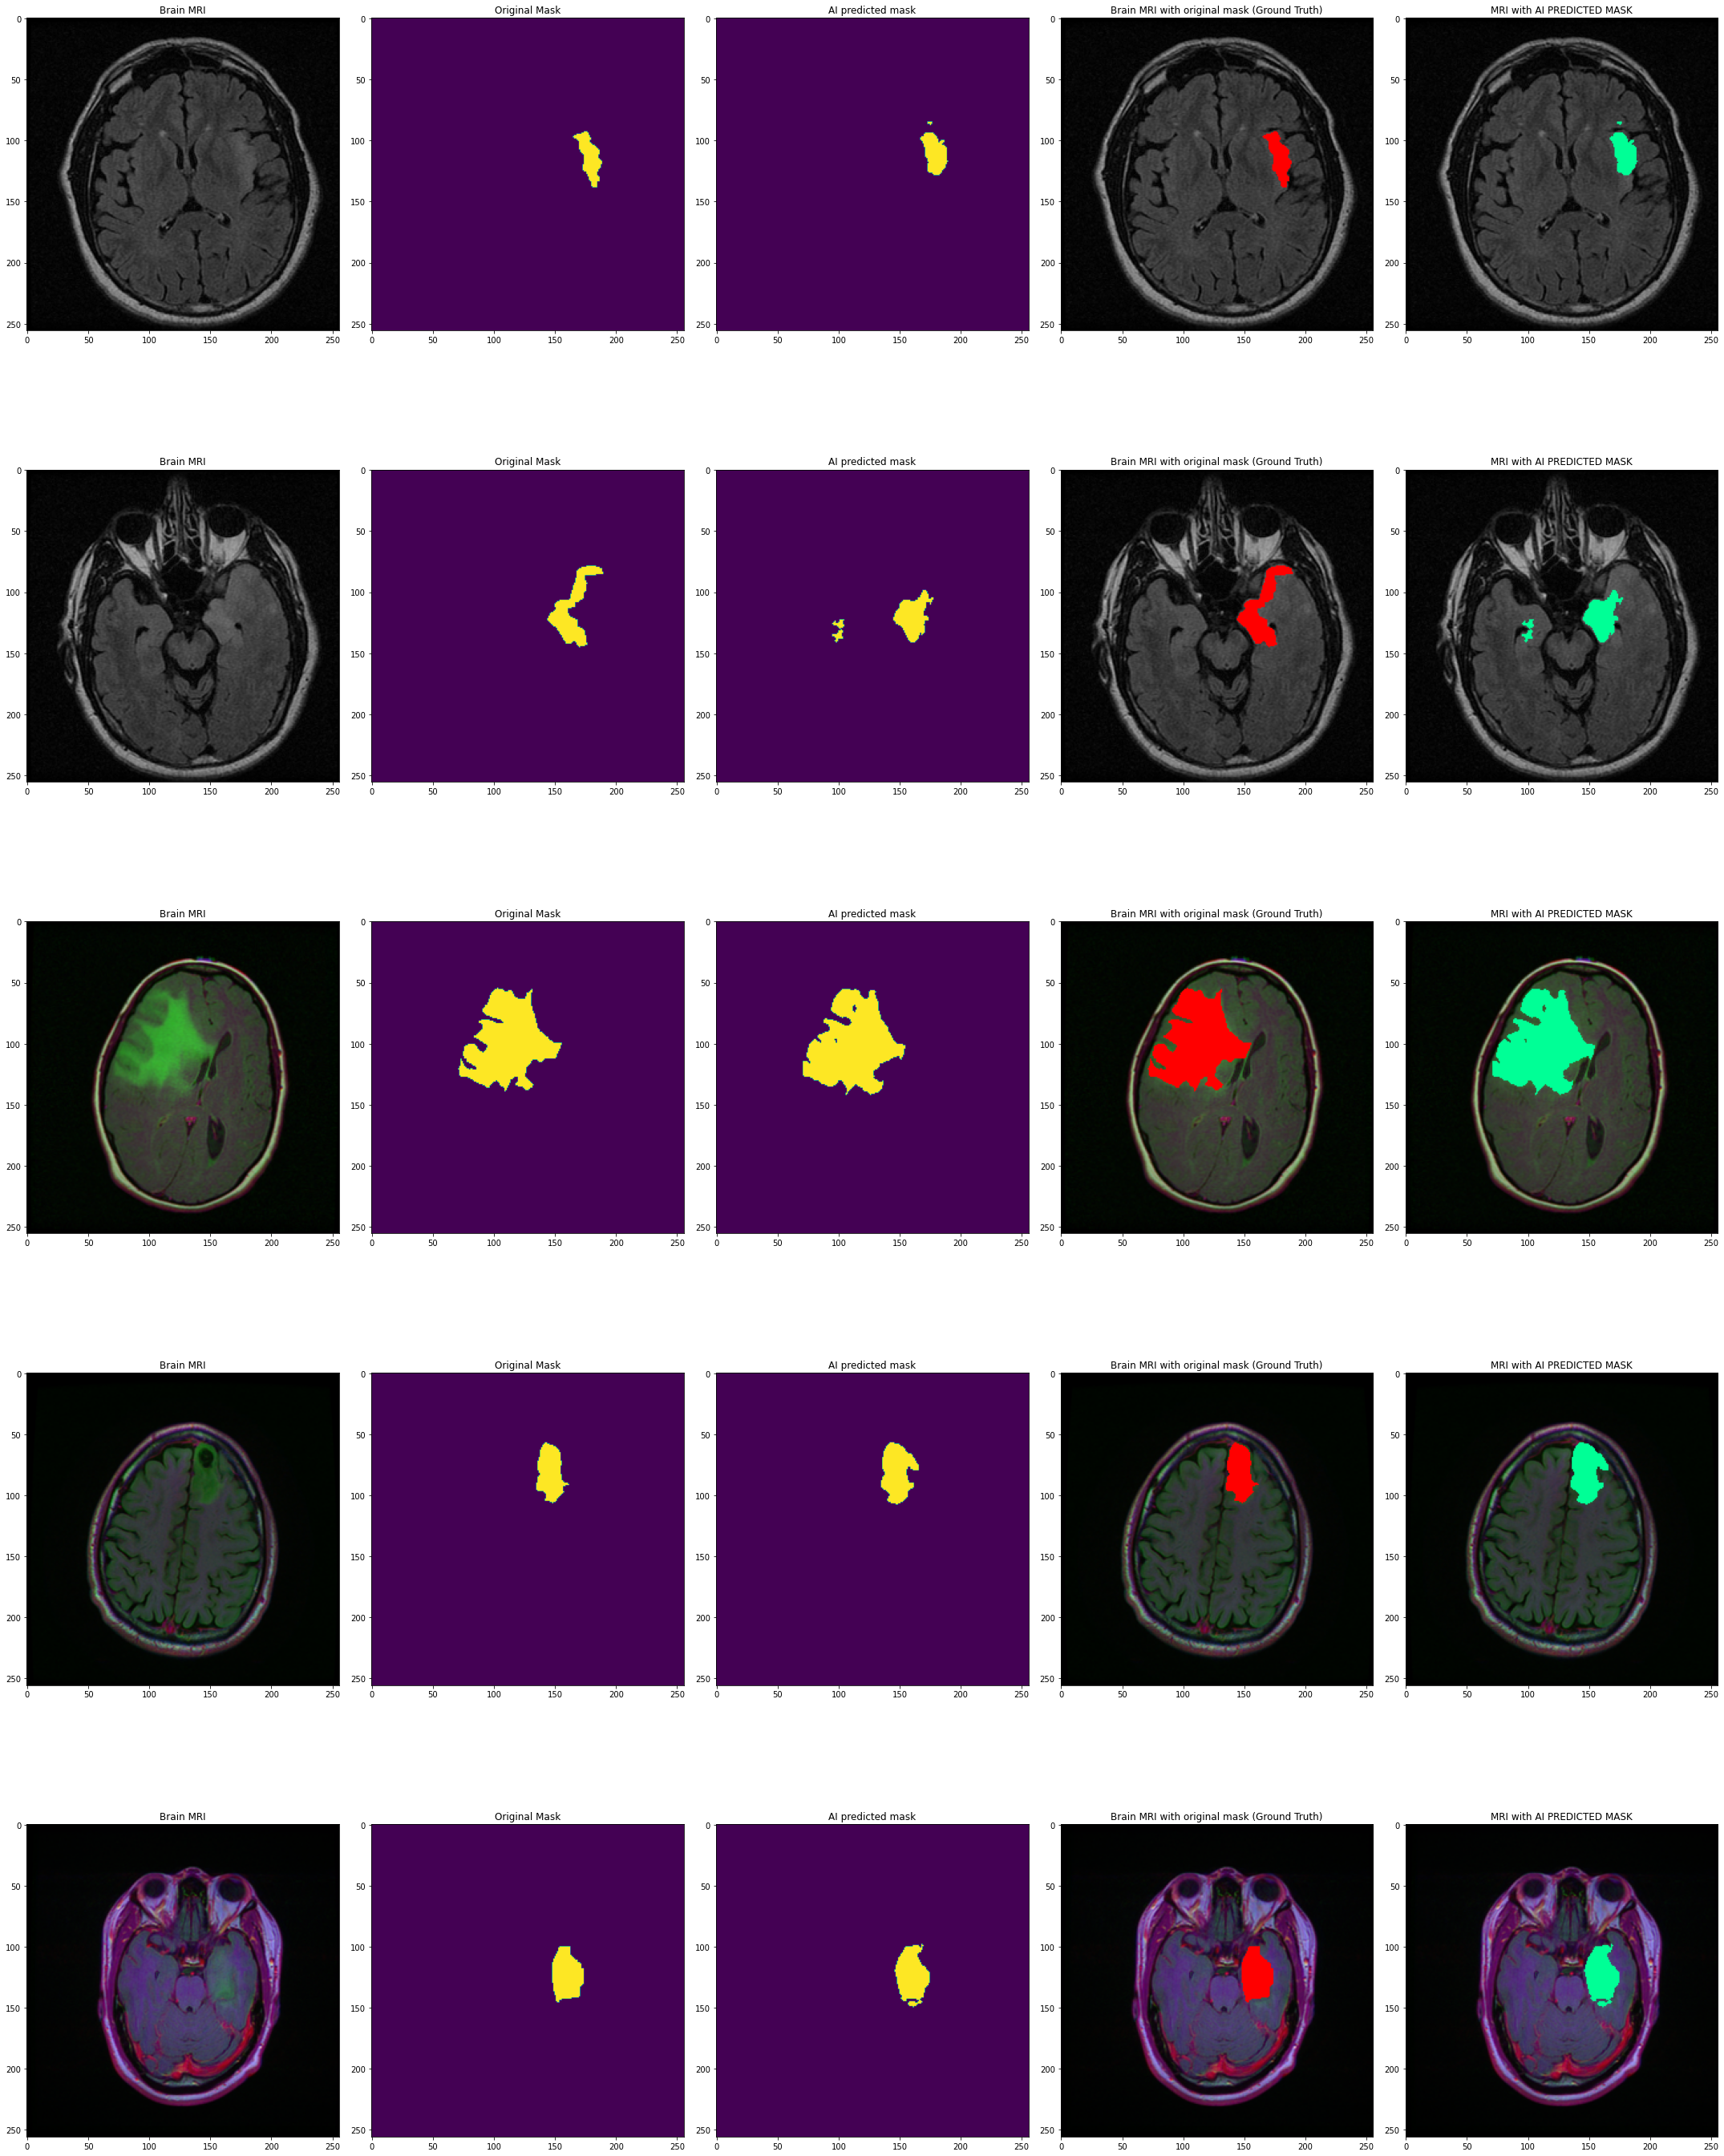

In [52]:
prediction_with_seg_vis(model, seg_model, h)

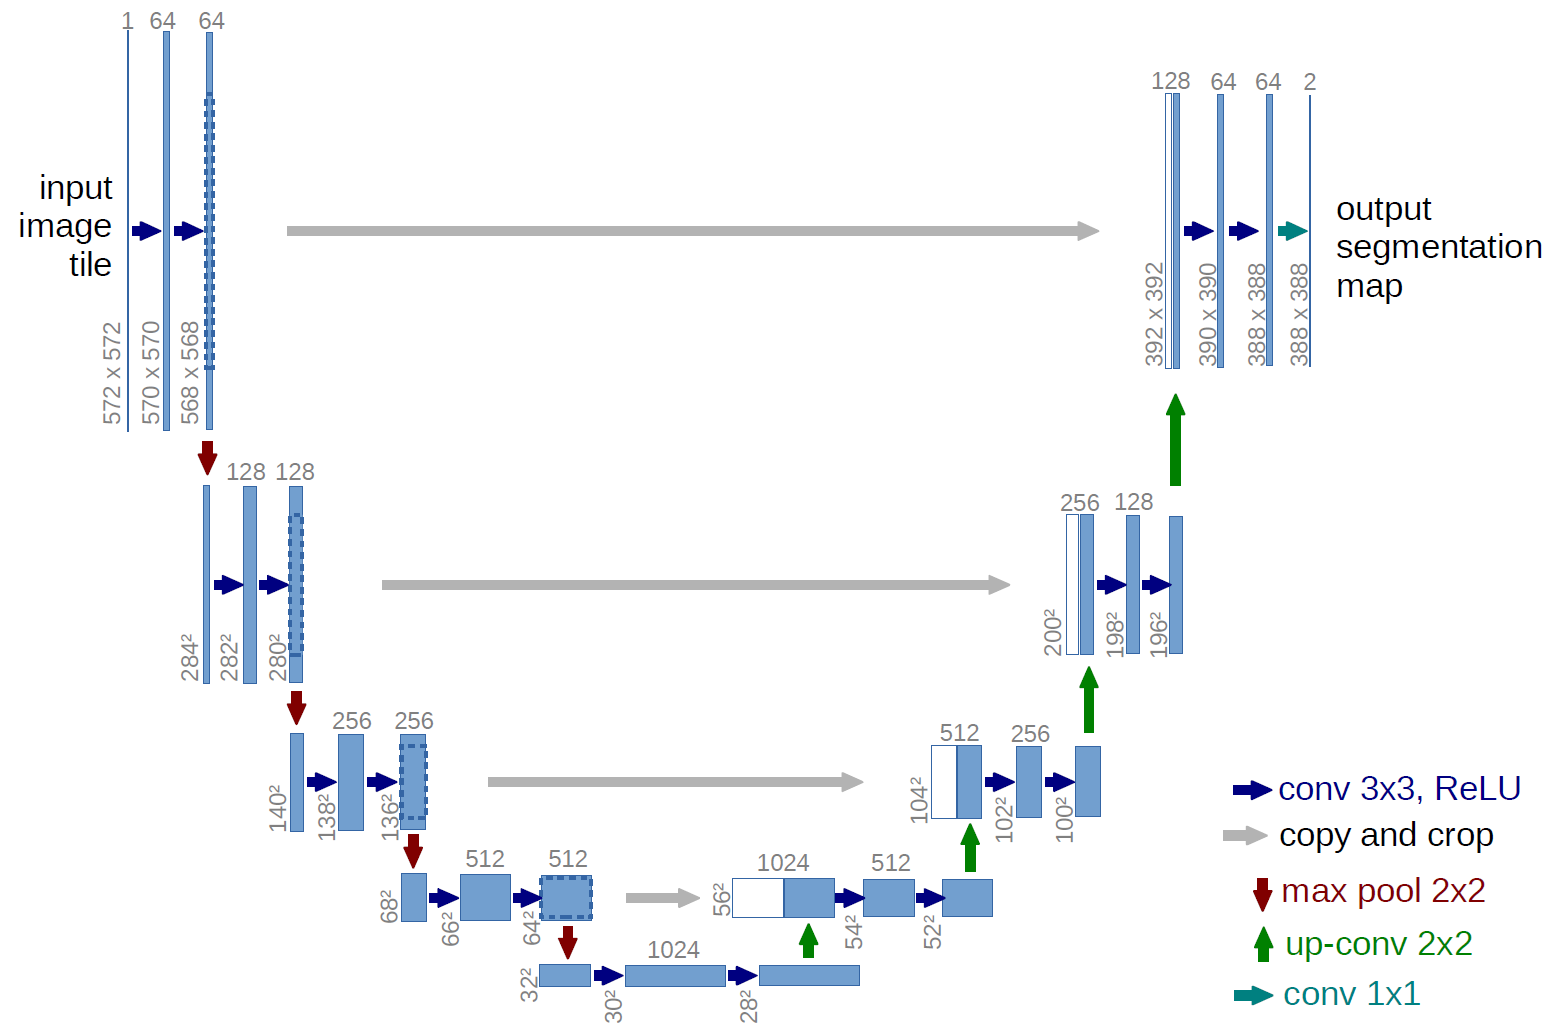

## **VGGUNET Architecture**

In [53]:
def vggUnet (input_h, input_w, channel_first=True):
  ## Input shape channel last architecture
  img_input = Input(shape=(input_h, input_w,3))
  x = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(img_input)
  x = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
  x = BatchNormalization()(x)
  f1 = x
  x = MaxPooling2D((2,2), strides=(2,2), name='block1_pool1')(x)
  
  #Block 2

  x = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
  x = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
  x = BatchNormalization()(x)
  f2 = x
  x = MaxPooling2D((2,2), strides=(2,2))(x)
  

  #Block 3
  x = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
  x = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
  x = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
  x = BatchNormalization()(x)
  f3 = x
  x = MaxPooling2D((2,2), strides=(2,2))(x)
  

  #Block 4
  x = Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
  x = Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
  x = Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
  x = BatchNormalization()(x)
  f4 = x
  x = MaxPooling2D((2,2), strides=(2,2))(x)
  

  #Block 4
  x = Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
  x = Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
  x = Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
  x = BatchNormalization()(x)
  
  
  f5 = x
  

  u = f5
  u = (ZeroPadding2D((1,1)))(u)
  u = (Conv2D(512, (3,3), activation='relu', padding='valid'))(u)
  u = (BatchNormalization())(u)
  u = (UpSampling2D((2,2)))(u)
  # first concat
  u = (concatenate([u,f4]))

  #Next Upsampling
  u = (ZeroPadding2D((1,1)))(u)
  u = (Conv2D(256, (3,3), activation='relu'))(u)
  u = (BatchNormalization())(u)
  u = (UpSampling2D((2,2)))(u)
  # first concat
  u = (concatenate([u,f3]))
  
  # Next upsampling

  u = ZeroPadding2D((1,1))(u)
  u = Conv2D(128, (3,3), activation='relu')(u)
  u = BatchNormalization()(u)
  u = UpSampling2D((2,2))(u)
  # first concat
  u = concatenate([u,f2])
 
  # #Next Upsampling
  u = ZeroPadding2D((1,1))(u)
  
  u = Conv2D(64, (3,3), activation='relu')(u)
  u = BatchNormalization()(u)
  u = UpSampling2D((2,2))(u)
  
  # first concat
  u = concatenate([u,f1])
  
  u = Conv2D(1,(1,1), activation='sigmoid', kernel_initializer='he_normal')(u)
  model = Model(img_input, u)
  return model


In [55]:
vgg_model = vggUnet(256,256)

In [56]:
vgg_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_72 (Conv2D)              (None, 256, 256, 64) 1792        input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_73 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_72[0][0]                  
__________________________________________________________________________________________________
batch_normalization_61 (BatchNo (None, 256, 256, 64) 256         conv2d_73[0][0]                  
____________________________________________________________________________________________

In [58]:
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
vgg_model.compile(optimizer = adam, 
                  loss = focal_tversky, 
                  metrics = [tversky]
                 )
#callbacks
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min', 
                              verbose=1, 
                              patience=20
                             )
# save the best model with lower validation loss
checkpointer_vgg = ModelCheckpoint(filepath="VGGUNet1-segModel-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )

In [59]:
with tf.device("/GPU:0"):
  vgg_ = vgg_model.fit(train_data, 
                  epochs = 100, 
                  validation_data = val_data,
                  callbacks = [earlystopping,checkpointer_vgg, reduce_lr]
                 )

Epoch 1/100
72/72 [==============================] - 44s 452ms/step - loss: 0.8533 - tversky: 0.1901 - val_loss: 0.8013 - val_tversky: 0.2555

Epoch 00001: val_loss improved from inf to 0.80129, saving model to VGGUNet1-segModel-weights.hdf5
Epoch 2/100
72/72 [==============================] - 33s 450ms/step - loss: 0.6905 - tversky: 0.3874 - val_loss: 0.4448 - val_tversky: 0.6580

Epoch 00002: val_loss improved from 0.80129 to 0.44481, saving model to VGGUNet1-segModel-weights.hdf5
Epoch 3/100
72/72 [==============================] - 33s 453ms/step - loss: 0.3884 - tversky: 0.7149 - val_loss: 0.6000 - val_tversky: 0.4898

Epoch 00003: val_loss did not improve from 0.44481
Epoch 4/100
72/72 [==============================] - 33s 458ms/step - loss: 0.3141 - tversky: 0.7843 - val_loss: 0.4631 - val_tversky: 0.6381

Epoch 00004: val_loss did not improve from 0.44481
Epoch 5/100
72/72 [==============================] - 33s 460ms/step - loss: 0.2656 - tversky: 0.8278 - val_loss: 0.3127 - va

6/6 [==============================] - 1s 141ms/step - loss: 0.1651 - tversky: 0.9093
Segmentation tversky is 90.93%
Prediction Accuracy is 89.32039%


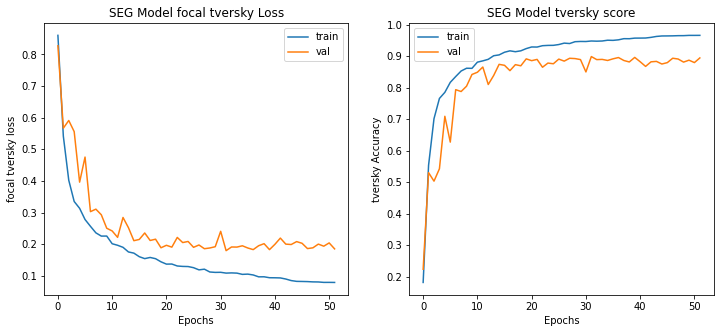

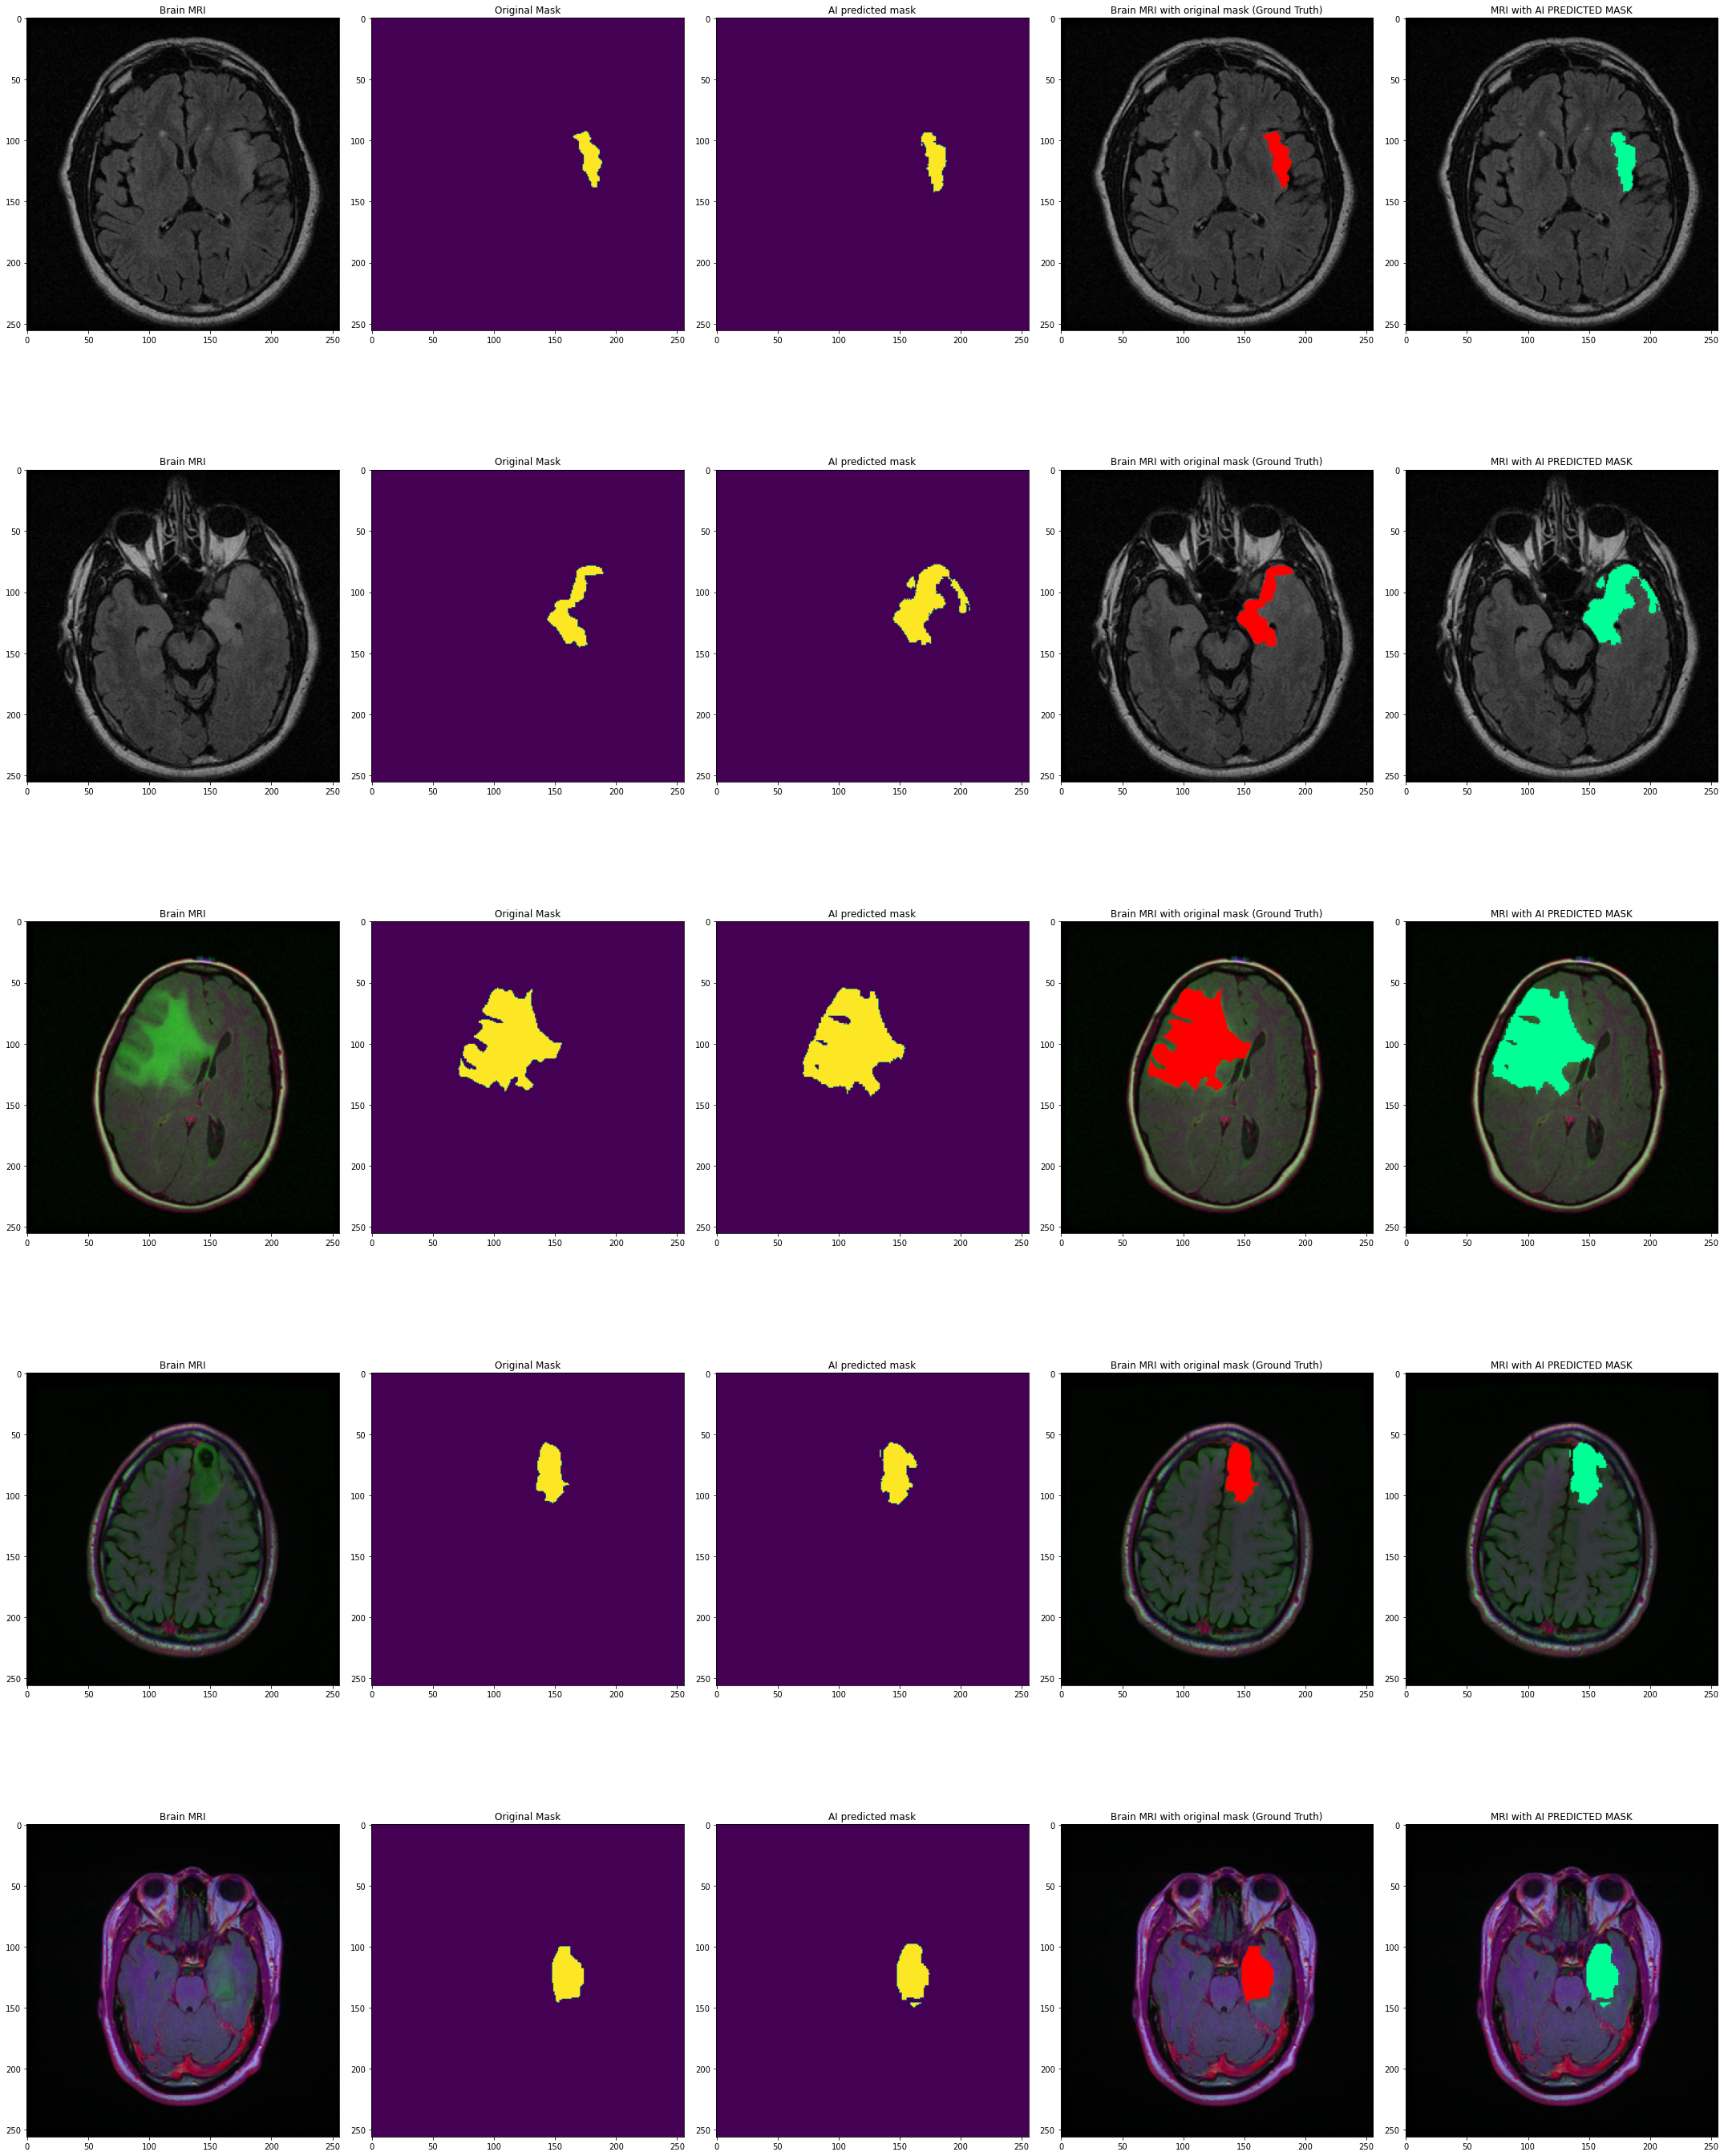

In [60]:
# making prediction
prediction_with_seg_vis(model, vgg_model, vgg_)

In [61]:
from keras.utils.vis_utils import plot_model

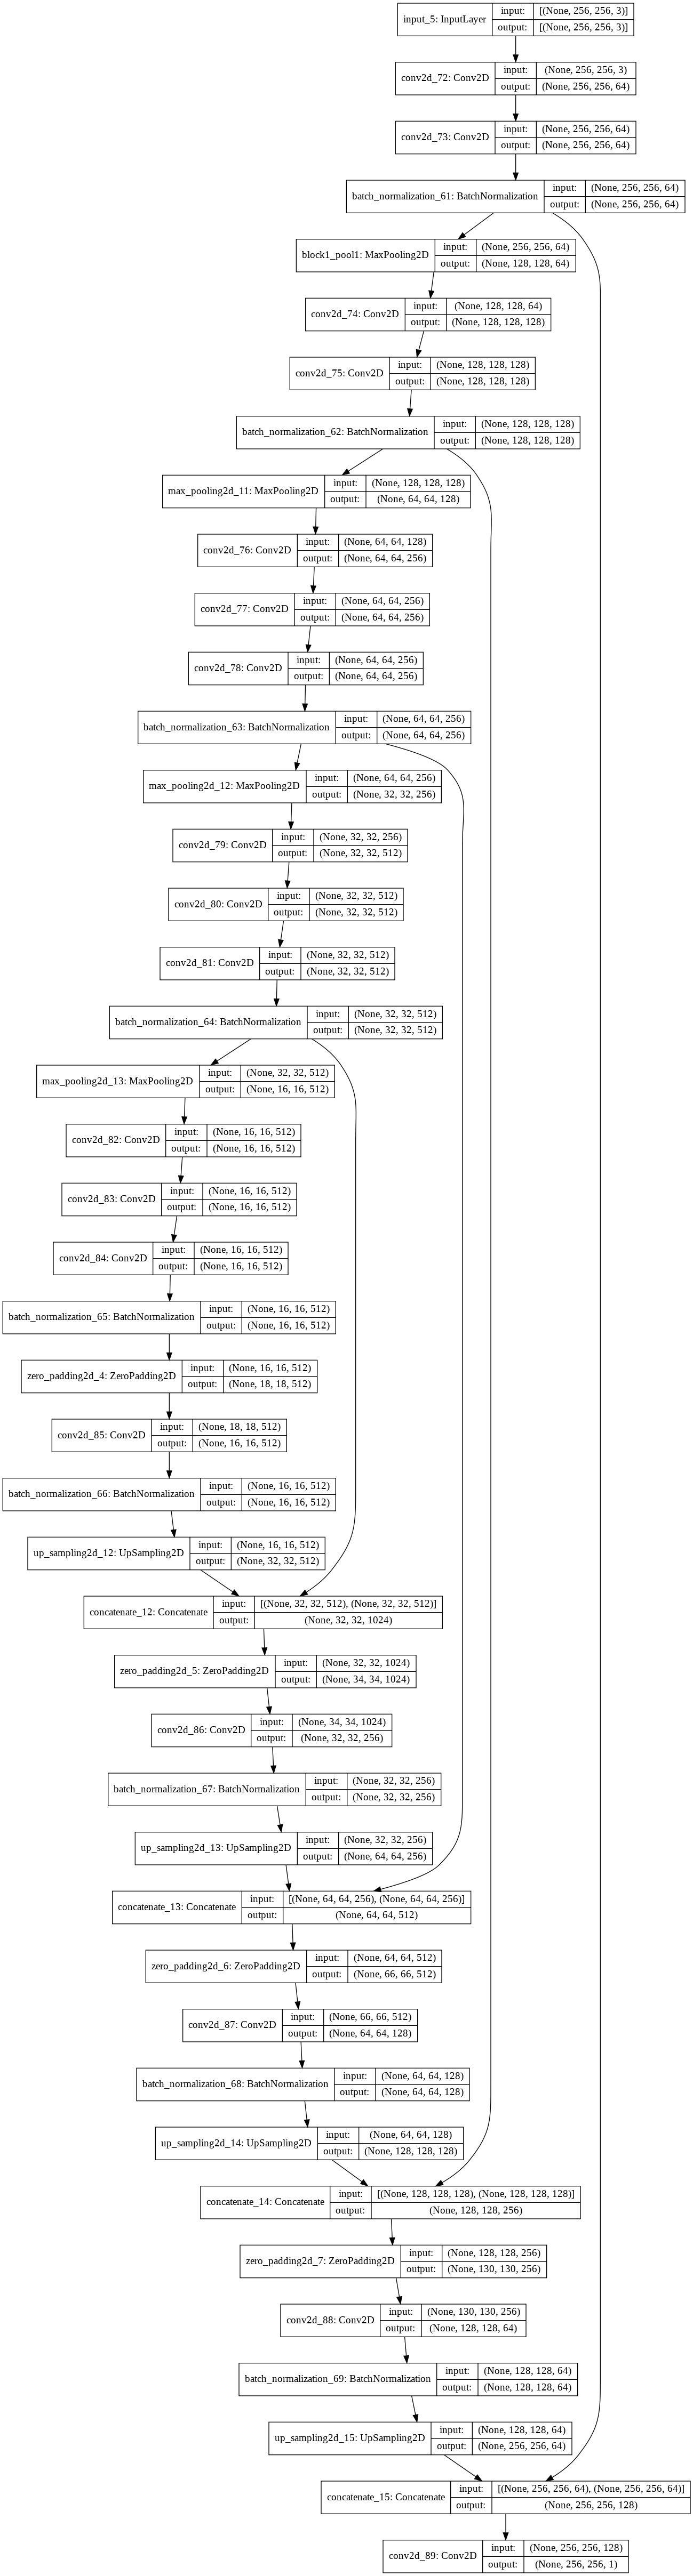

In [68]:
plot_model(vgg_model, to_file='/content/drive/MyDrive/ML Project/models/vggUnet.png', show_shapes=True)

In [63]:
vgg_model.save('/content/drive/MyDrive/ML Project/models/VggUnet_Segmen_model.h5')

In [64]:
vgg_model.save_weights('/content/drive/MyDrive/ML Project/models/VggUnet_Segmen_model_weights.h5')

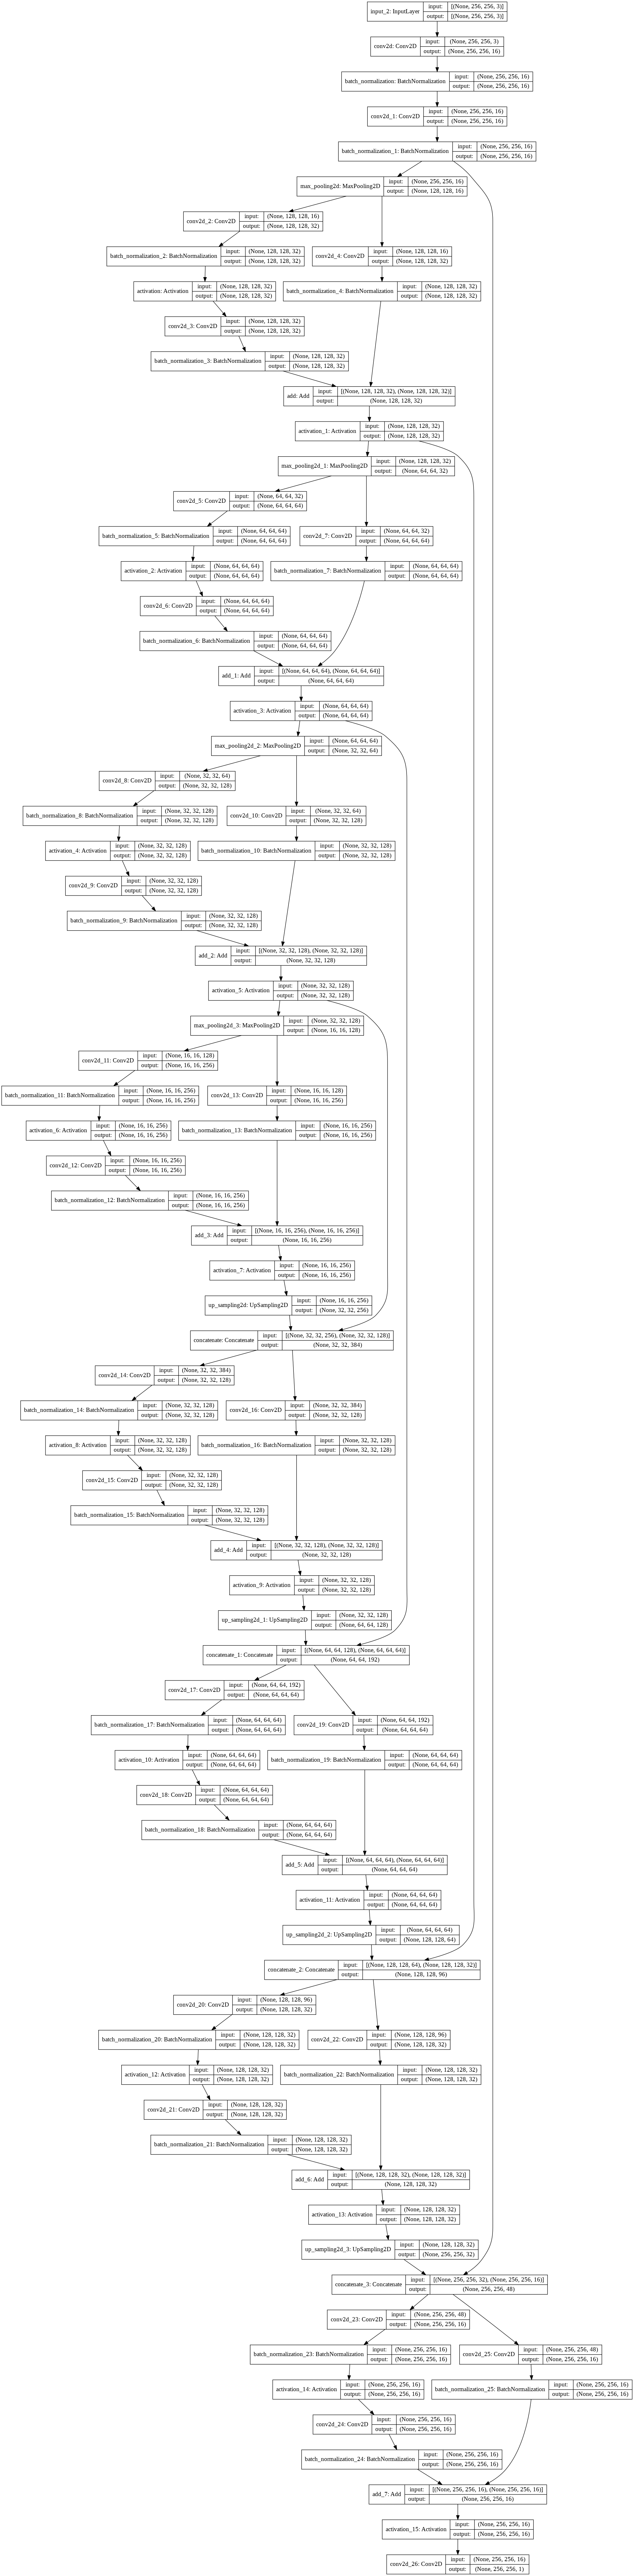

In [69]:
plot_model(seg_model, to_file='/content/drive/MyDrive/ML Project/models/resUnet.png', show_shapes=True)